In [1]:
import numpy as np
import scipy as sp
import time, datetime
import os
import shutil
from skimage.io import imread
import pandas as pd
from skimage import img_as_float
import matplotlib.pyplot as plt
from scipy import optimize
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, make_scorer, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

%matplotlib inline

# 0.1 Set of functions to fit an image with a gaussian

In [2]:
def gaus_moments(data):
    """Returns a dict containing initial guesses for 2D-Gaussian parameters: 
    (background, amplitude, x_mean, y_mean, sigma_x, sigma_y)
    
    Assuming that image is approximately centered"""
    total = data.sum()
    Y, X = np.indices(data.shape)
    x = data.shape[0]/2 #(X*data).sum()/total
    y = data.shape[1]/2 #(Y*data).sum()/total
    col = data[:, int(y)]
    sigma_y = np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum()
    row = data[int(x), :]
    sigma_x = np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum()
    height = data.min()
    amplitude = data.max() - height
    mom={'background':height, 'amplitude':amplitude, 'x_mean':x, 'y_mean':y, 'sigma_x':sigma_x, 'sigma_y':sigma_y}
    return mom

In [3]:
def twod_gaussian(height, amplitude, center_x, center_y, sig_x, sig_y, sig_xy):
    """Returns a gaussian function with the given parameters"""
    #Sigma = [[sig_x, sig_xy], [sig_xy, sig_y]]
    Sigmin= [[sig_y, -sig_xy], [-sig_xy, sig_x]]/(sig_x*sig_y - sig_xy**2 + 10**-4)
    center = np.array([center_x, center_y]).reshape((1,1,2))
    #print (center.shape, Sigmin.shape, center.dot(Sigmin).shape)
    return lambda x: height+ amplitude*np.exp(-( (x-center).dot(Sigmin)*(x-center) ).sum(axis=-1)/2)

In [4]:
def fit_gaussian(data):
    """Returns 2D-Gaussian fit parameters:
    (height, amplitude, center_x, center_y, sig_x, sig_y, sig_xy)
    found by a optimizing least squares of an error"""
    mome = gaus_moments(data)
    para = [mome['background'], mome['amplitude'], mome['x_mean'], mome['y_mean'], mome['sigma_x'], mome['sigma_y'], 1.2]
    x = np.stack(np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1])), axis=-1)
    errorfunction = lambda p: np.ravel(twod_gaussian(*p)(x) - data)
    p, success = sp.optimize.leastsq(errorfunction, para)
    #print (success)
    return p

## 0.2 Set of functions for processing the data

In [5]:
def load_imgs(dir_name='dust_fog', numb = 10):
    """
    FROM MY LAPTOP
    
    Loading 'numb' of images from 'dir_name'
    and reshaping each one into 8 polarization images of shape 30x30
    -------
    Output:   numpy array of shape 'numb' x 8 x 30 x 30
    """
    dir_name = 'D:/NEWSdm/crops/'+dir_name
    img_arr = []
    num_i = 0
    for img_name in os.listdir(dir_name):
        num_i += 1
        if num_i > numb :
            break
        tmp_im = (pd.read_csvos.path.join(dir_name, img_name), header=None).drop(30, axis=1)).values.reshape((8,30,30))
        img_arr.append(tmp_im)
    return np.array(img_arr)

In [6]:
def imgs_to_params(imgs):
    """
    Takes array (shape=[numb,8,30,30]) of numb x 8 images of shape 30 x 30
    and fits a 2D Gaussian on each of the images.
    -------
    Output: DataFrame with fitting parameters for images in the array.
    """
    params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
    for num in xrange(imgs.shape[0]):
        i=0
        for data in imgs[num]:
            par = np.concatenate(([num+1, i], fit_gaussian(data)))
            par = par.reshape((1,len(par)))
            i += 1
            params = params.append(pd.DataFrame(par,columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy']), ignore_index=True)
    return params

In [7]:
def clean_params(params, up_bound=500):
    """
    Dropping divergent samples (rows) from the dataset.
    Sample is divergent if any parameter (except 'sig_xy') is negative or larger than 'up_bound'
    """
    img_num = params.get('img_num')
    cov_xy = params.get('sig_xy')
    params = params.drop(['img_num','sig_xy'],axis=1)
    params = params[params[params<up_bound]>=0]
    params = pd.concat([img_num, params, cov_xy], axis=1, join='inner')
    return params.dropna()

In [8]:
def params_to_features(params):
    """
    Getting physical features from fitting parameters:
    polarization number, amplitude, center position, rotation (represented by 'sig_xy'), minor axis, eccentrisity, area
    -------
    Output: DataFrame with features for every image
    """
    Sigms = params.get(['sig_x','sig_y','sig_xy']).values
    idx = params.index
    #print (Sigms.shape)
    a_ar = []
    area_ar = []
    eps_ar = []
    for s in Sigms:
        #print (s)
        a, b = np.linalg.eigvalsh([[s[0],s[2]],[s[2],s[1]]])
        if a>b:
            tmp = a
            a = b
            b = tmp
        a_ar.append(a)
        area_ar.append(np.pi * a * b)
        eps = b/a
        if eps<1: eps = 1/eps
        eps_ar.append(eps)
    ellip_par = pd.DataFrame(data={'minor_ax':a_ar, 'eps':eps_ar, 'area':area_ar}, index=idx)
    #print (ellip_par.shape)
    feat = params.drop(['img_num','height','sig_x','sig_y'],axis=1)
    feat = pd.concat([feat, ellip_par], axis=1)
    return feat

In [9]:
def feat_to_input(ft_data, cl_names):
    """
    Stacking data with names from 'cl_names' into one DataFrame labeling 'signal' with 1 and 'noise' with 0.
    """
    inp_data = pd.DataFrame(columns=np.concatenate((['target'], ft_data[cl_names[0]].columns.values)) )
    for name in cl_names:
        idx = ft_data[name].index
        if name[0] == 'C' :
            targ = pd.DataFrame(data={'target':np.ones(len(idx))}, index=idx)
        else: targ = pd.DataFrame(data={'target': np.zeros(len(idx))}, index=idx)
        app_data = pd.concat([targ, ft_data[name]], axis=1)
        inp_data = inp_data.append(app_data, ignore_index=True)
    return inp_data    

In [168]:
def clean_quantile_feat(params, quant = 0.999):
    """
    Dropping few percent most outlying samples using quantiles. Dropping symmetrically for distributions assumed symmetrical.
    'quant' can be a dict with feature names or just a number.
    """
    if 'polar' in params.columns:
        polar = params.get('polar')
        params = params.drop(['polar'],axis=1)
    for key in params.keys():
        if type(quant) == type({}):
            params = params[ params[key]<params[key].quantile(quant[key]) ]
            if (key[0] == 'c') or (key[0] == 's'):
                params = params[ params[key]>params[key].quantile(1-quant[key]) ]
        else:
            params = params[ params[key]<params[key].quantile(quant) ]
            if (key[0] == 'c') or (key[0] == 's'):
                params = params[ params[key]>params[key].quantile(1-quant) ]
    if 'polar' in params.columns:
        params = pd.concat([polar, params], axis=1, join='inner')
    return params.dropna()

### 0.2.1 Special functions for large data samples

In [11]:
# should be improved

def load_and_fit_batches(class_name='dust_fog', numb = 10000, node=1, n_cpu=1, n_0 = 1000):
    """
    FROM MY LAPTOP
    
    Loading 'numb' of samples in total from 'class_name' and fitting them with Gaussians and writing results files.
    1. Taking 'n_0' samples at a time and rewriting the same variables on each iteration.
    2. Pseudo-parallelised by running 'n_cpu' applications at once by hands with different 'node' numbers.
    -------
    Output:
    Written 'csv' files with fitting parameters in specific folders, returns 'nump' totall number of samples processed.
    The resulting files are like 'D:/NEWSdm/crops/csvs/batches/50000/gamma/cpu3_n1_it1_params.csv'
    
    *Important*: 'numb' must be devidible by 'n_0', otherwise up to 'n_0' extra samples wil be processe.
    """
    #Getting the number of iterations on this node.
    i_m = np.int(float(numb)/(n_0 * n_cpu))
    over = np.ceil((float(numb) - i_m*n_0*n_cpu)/n_0)
    if node <= over:
        i_m +=1 # each node has it's own i_m
        
    
    dir_name = 'D:/NEWSdm/crops/'+class_name
    nump = 0
    img_names = os.listdir(dir_name)
    for i in range(i_m):
        #iterating over samples in the batch
        img_arr = []
        for img_name in img_names[(node+i-1)*n_0 : (node+i)*n_0]:
            tmp_im = (pd.read_csv(os.path.join(dir_name, img_name), header=None).drop(30, axis=1)).values.reshape((8,30,30))
            img_arr.append(tmp_im)
        img_arr = np.array(img_arr)
        #getting parametrs of samples in the batch and writing tham to file.
        params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
        for img_num in np.arange(img_arr.shape[0]):
            polar=1
            for data in img_arr[img_num]:
                par = np.concatenate(([img_num+1, polar], fit_gaussian(data)))
                par = par.reshape((1,len(par)))
                polar += 1
                nump += 1
                params = params.append(pd.DataFrame(par,columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy']), ignore_index=True)
        output_name = str(numb)+'/'+class_name+'/cpu'+str(n_cpu)+'_n'+str(node)+'_it'+str(i+1)+'_params'
        params.to_csv('D:/NEWSdm/crops/csvs/batches/'+output_name+'.csv')
    '''
    Пофиксить что самая последняя итерация выбегает за пределы, если не делится нацело.
    '''
    return nump

In [12]:
def read_params_from_names(numb, name):
    """
    Reading and stacking DataFrames with parameters from the specified directory: 
    C:/Artem/NEWS/params/batches/'numb'/name
    """
    dir_name = 'C:/Artem/NEWS/params/batches/'+str(numb)+'/'+name
    params = pd.DataFrame(columns=['img_num', 'polar', 'height', 'amplitude', 'center_x', 'center_y', 'sig_x', 'sig_y', 'sig_xy'])
    for img_name in os.listdir(dir_name):
        par = pd.read_csv(os.path.join(dir_name, img_name), index_col=0)
        params = params.append(par, ignore_index=True)
    return params

In [13]:
def load_params_to_feat(numb, cl_names, giant=False):
    """
    Reading parameters from files, cleaning them and transforming into features.
    -------
    Output: Dict with features DataFrame for every class name
    """
    dat_params = {}
    ft_data = {}
    for name in cl_names:
        if giant:
            dat_params[name] = read_params_from_names(numb, name)
        else: dat_params[name] = pd.read_csv('C:/Artem/NEWS/params/'+str(numb)+'_'+name+'_params.csv', index_col=0)
        ft_data[name] = params_to_features( clean_params(dat_params[name]) )
    return ft_data

In [14]:
def feat_to_input_split(ft_data, cl_names, test_size=0.1, shuffle=True):
    """
    Splitting data for train-test with or without shuffle.
    Stacking specified classes together considering target label (signal/background).
    -------
    Output: X_train, X_test, y_train, y_test
    """
    if shuffle:
        inp_data = feat_to_input(ft_data, cl_names)
        X = inp_data.drop(['target'], axis=1).values
        y = inp_data.get('target').values
        X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, test_size=test_size)
    else:
        y_tr = pd.DataFrame().values
        y_tt = pd.DataFrame().values
        X_tr = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
        X_tt = pd.DataFrame(columns=ft_data[cl_names[0]].columns).values
        for name in cl_names:
            if name[0]=='C': 
                y = np.ones(ft_data[name].shape[0])
            else: y = np.zeros(ft_data[name].shape[0])
            X = ft_data[name].values
            tmp_X_tr, tmp_X_tt, tmp_y_tr, tmp_y_tt = train_test_split(X, y, test_size=test_size, shuffle=False)
            X_tr = np.vstack((X_tr, tmp_X_tr))
            X_tt = np.vstack((X_tt, tmp_X_tt))
            y_tr = np.append(y_tr, tmp_y_tr)
            y_tt = np.append(y_tt, tmp_y_tt)
            
    return X_tr, X_tt, y_tr, y_tt

### 0.2.2 Functions for all polarisations stacked together

In [36]:
def params_to_stacked_polar(params, n_pol=8):
    """
    
    """
    pol_par = pd.DataFrame()
    for i in range(params.shape[0]//n_pol):
        par_slice = params[(i*8):((i+1)*8)]
        par_slice = pd.DataFrame(par_slice.drop(['img_num','polar'],axis=1).values, index=par_slice.get('polar'), columns=par_slice.drop(['img_num','polar'],axis=1).columns)
        #print (par_slice.head(2), '\n')
        flat_slice = pd.DataFrame(index=[i])
        for j in np.arange(1,n_pol+1):
            col_slice = np.append(flat_slice.columns.values, [opa+str(int(j)) for opa in par_slice.loc[j].index.values])
            #print (col_slice)
            flat_slice = pd.DataFrame(np.append(flat_slice.values, par_slice.loc[j].values).reshape((1,-1)), columns=col_slice, index=[i])
        pol_par = pd.concat([pol_par, flat_slice])
    return pol_par

In [16]:
def clean_stacked_params(params, up_bound=500, n_pol=8):
    """
    Dropping divergent samples (rows) from the dataset.
    Sample is divergent if any parameter (except 'sig_xy') is negative or larger than 'up_bound'
    """
    img_num = params.index
    for par in params.columns:
        if par[:6] != 'sig_xy':
            params = params[ params[par]>=0 ]
        params = params[ params[par]<up_bound ]
    print (params.shape)
    return params.dropna()

In [122]:
def params_to_feat_stacked(params, n_pol=8):
    """
    
    """
    idx = params.index
    feat = params.copy()
    for i in np.arange(1,n_pol+1):
        Sigms = params.get(['sig_x'+str(i),'sig_y'+str(i),'sig_xy'+str(i)]).values
        a_ar = []
        area_ar = []
        eps_ar = []
        b_ar = []
        for s in Sigms:
            a, b = np.linalg.eigvalsh([[s[0],s[2]],[s[2],s[1]]])
            if a>b:
                tmp = a
                a = b
                b = tmp
            a_ar.append(a)
            area_ar.append(np.pi * a * b)
            b_ar.append(b)
            eps_ar.append(b/a)
        ellip_par = pd.DataFrame(data={'min_ax'+str(i):a_ar, 'maj_ax'+str(i):b_ar, 'eps'+str(i):eps_ar, 'area'+str(i):area_ar}, index=idx)
        feat = feat.drop(['height'+str(i),'sig_x'+str(i),'sig_y'+str(i)],axis=1)
        feat = pd.concat([feat, ellip_par], axis=1)
        
    for i in np.arange(n_pol, 0, -1):
        tmp_feat = feat.drop(feat.columns, axis=1)
        for col in feat.columns:
            if col[-1]==str(i):
                tmp_feat = pd.concat([tmp_feat, feat[col]], axis=1)
                feat = feat.drop([col], axis=1)
        feat = pd.concat([tmp_feat, feat], axis=1)
    return feat

In [190]:
def drop_import_feat(ft_data, imp_ft, n_drop, shuffle_ft=False):
    """
    Dropping 'n_drop' most important features from 'imp_ft' importance list. 'shuffle' key imposes random droping.
    """
    imp_cols = (ft_data.columns)[np.argsort(imp_ft)].values
    if shuffle_ft: np.random.shuffle(imp_cols)
    return ft_data.drop(imp_cols[-n_drop:], axis=1)

In [156]:
def shift_polar_feats(params, n_shift = 1, n_pol = 8):
    """
    Shifting polarizations ins the features to the right:
    (1-2-3) -> (3-1-2)
    """
    for i in range(n_shift):
        shift = params.get(params.columns[ -len(params.columns)//8 : ])
        params = pd.concat([shift, params.drop(params.columns[ -len(params.columns)//8 : ], axis=1)], axis=1)
    return params    

In [18]:
class_names = ['C60keV','C80keV','C100keV','dust_fog','gamma']

## 1. Training on 20k samples of each type

In [19]:
repeated = False

##### 1.1 Fitting the images and saving parameters into files
* _repeated_ is for recreating the output directory if you are running the same number of samples not for the first time
* 20000 images on two nodes ~14hours

```
%%time
numb = 20000
if repeated:
    shutil.rmtree('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/')
os.mkdir('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/')
giant_data_numb = {}
for name in class_names:
    os.mkdir('D:/NEWSdm/crops/csvs/batches/'+str(numb)+'/'+name+'/')
    repeated = True
    giant_data_numb[name] = load_and_fit_batches(class_name=name, numb=numb, node=1, n_cpu=2)
```

##### 1.2 Loading files with Gaussian parameters and transforming them to input features

In [20]:
%%time
##### Loading previosly saved parameters
numb = 20000

giant_data_params = {}
for name in class_names:
    giant_data_params[name] = read_params_from_names(numb, name)


##### Droping the samples where fit diverges

cleaned_giant_data = {}
for name in class_names:
    cleaned_giant_data[name] = clean_params(giant_data_params[name])


print ('cleaned data shape')

for (key,value) in cleaned_giant_data.items():
    print (key,'  \t', value.shape)

##### Transforming fitting parameters into physical features of the image

feat_giant_data = {}
for name in class_names:
    feat_giant_data[name] = params_to_features(cleaned_giant_data[name])
    
##### Merging all data into one DataFrame with appropriate target labels (signal/noise)

input_giant_data = feat_to_input(feat_giant_data, class_names)

print (input_giant_data.shape, '\n\n', input_giant_data.head(1))

#### Spliting data into train and test
# * Precision is the scorer

X_giant = input_giant_data.drop(['target'], axis=1).values
y_giant = input_giant_data.get('target').values
X_giant_train, X_giant_test, y_giant_train, y_giant_test = train_test_split(X_giant, y_giant, test_size=0.1, stratify=y_giant)

prec_scorer = make_scorer(precision_score)

cleaned data shape
C60keV   	 (131833, 9)
C80keV   	 (103013, 9)
C100keV   	 (147079, 9)
dust_fog   	 (120861, 9)
gamma   	 (145447, 9)
(648233, 9) 

    target  polar  amplitude   center_x   center_y    sig_xy       area  \
0     1.0    1.0   5.108879  14.329652  14.817351  0.001597  87.683335   

        eps  minor_ax  
0  1.844835  3.889599  
Wall time: 16.1 s


## 2. Training Random Forest

In [21]:
randcla = RandomForestClassifier(n_jobs=-1)

##### 2.1 Cross-validation on 5 folds for small amount of trees

**2.1.1** Using precision as a quality metrics

In [22]:
%%time
giant_rand_scores = []
giant_rand_var = []
n_est = [10, 20, 50, 100, 200]
for n in n_est:
    randcla.set_params(n_estimators=n)
    sco = cross_val_score(randcla, X_giant_train, y_giant_train, scoring=prec_scorer, cv=5)
    giant_rand_scores.append(sco.mean())
    giant_rand_var.append(sco.var())
    print (np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%')

0.985 +/- 0.0 %
0.985 +/- 0.0 %
0.985 +/- 0.0 %
0.985 +/- 0.0 %
0.984 +/- 0.0 %
Wall time: 4min 20s


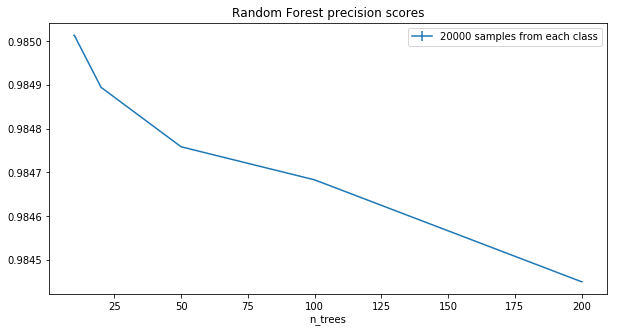

In [23]:
n_est = [10, 20, 50, 100, 200]
plt.figure(figsize=(10,5))
plt.errorbar(n_est, giant_rand_scores, yerr=giant_rand_var, label='20000 samples from each class')
plt.title('Random Forest precision scores')
plt.xlabel('n_trees')
plt.legend()
plt.savefig('RF_cv_20k.pdf')

**2.1.2** Checking accuracy as a quality metrics for 50 trees

In [24]:
%%time
randcla.set_params(n_estimators=50)
sco = cross_val_score(randcla, X_giant_train, y_giant_train, scoring='accuracy', cv=5)
print ('RF accuracy', np.around(sco.mean(),decimals=3), '+/-', np.around(100*sco.var()/sco.mean(), decimals=3), '%')

RF accuracy 0.985 +/- 0.0 %
Wall time: 38.9 s


##### 2.2 AUC-ROC and Precision-Recall curves

Detailed check of the algorithms performance for the number of trees that gave best result in previous section (_or 100 trees_)

Algorithm is trained and tested on different classes of signal-background **pair-wise**.

AUC_ROC scores
C60keV__dust_fog   	 0.9997817
C60keV__gamma   	 0.9998391
C80keV__dust_fog   	 0.999768
C80keV__gamma   	 0.9995349
C100keV__dust_fog   	 0.9998781
C100keV__gamma   	 0.9999013
Wall time: 31.3 s


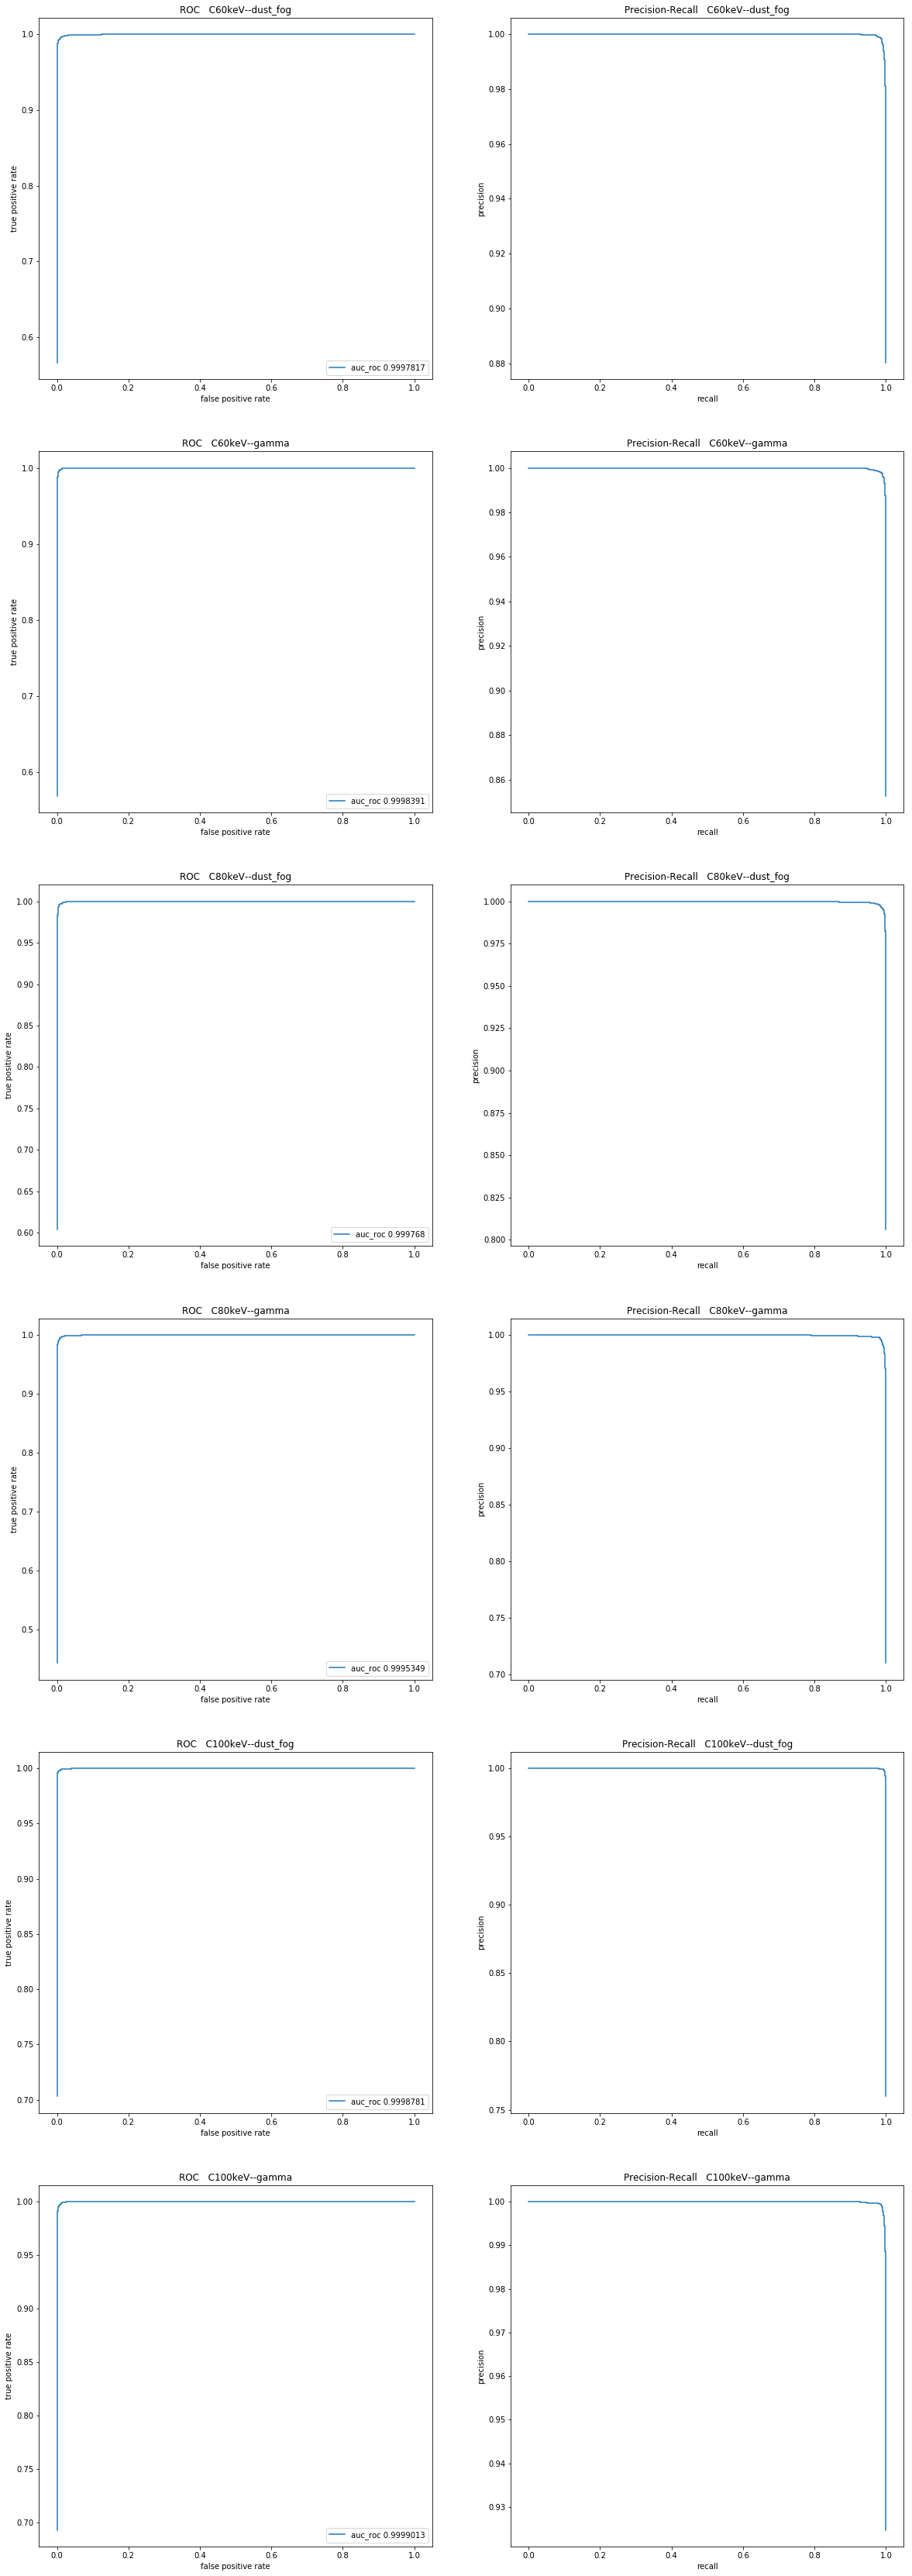

In [25]:
%%time
# Taking the best number of estimators from CV
#randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
randcla = RandomForestClassifier(n_estimators=100, n_jobs=-1)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_giant_data, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_raw, y_train)
            rand_pred = (randcla.predict_proba(X_test_raw))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print ('AUC_ROC scores')
for (key,value) in auc_rocs.items():
    print (key,'  \t', np.around(value, decimals=7))

##### 2.3 Performance for larger number of trees

Checking the behaviour of accuracy/precision/auc-roc/oob-score at the same time.

Training and testing on the whole signal vs whole background.

In [26]:
%%time
big_n_est = [50, 70, 130, 200, 350, 450, 600, 800, 1150, 1500, 1850, 2200, 3000, 5000, 10000]
forestzilla_accu = []
forestzilla_prec = []
forestzilla_aucroc = []
forestzilla_oob = []
forestzilla_feat_imp = []
print ('Scores oob(accuracy) vs accuracy vs precision vs auc_roc \t || \t time')
for n in big_n_est:
    tima = datetime.datetime.now()
    randcla.set_params(n_estimators = n, oob_score=True, n_jobs=-1)
    X_giant = input_giant_data.drop(['target'], axis=1).values
    y_giant = input_giant_data.get('target').values
    X_giant_train, X_giant_test, y_giant_train, y_giant_test = train_test_split(X_giant, y_giant, test_size=0.1, stratify=y_giant)
    
    randcla.fit(X_giant_train, y_giant_train)
    forestzilla_oob.append(randcla.oob_score_)
    forestzilla_feat_imp.append(randcla.feature_importances_)
    forestzilla_accu.append( accuracy_score(y_giant_test, randcla.predict(X_giant_test)) )
    forestzilla_prec.append( precision_score(y_giant_test, randcla.predict(X_giant_test)) )
    forestzilla_aucroc.append( roc_auc_score(y_giant_test, (randcla.predict_proba(X_giant_test))[:,1]) )
    print ('\t', np.around(forestzilla_oob[-1], decimals=4), '  \t', np.around(forestzilla_accu[-1], decimals=4), '  \t', np.around(forestzilla_prec[-1], decimals=4), '  \t', np.around(forestzilla_aucroc[-1], decimals=5), ' \t',str(n)+'_est_time: ', datetime.datetime.now()-tima)

Scores oob(accuracy) vs accuracy vs precision vs auc_roc 	 || 	 time


C:\Artem\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Artem\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


	 0.9702   	 0.9884   	 0.9917   	 0.9992  	 10_est_time:  0:00:05.397592
	 0.9912   	 0.9929   	 0.9931   	 0.99974  	 50_est_time:  0:00:17.604897
	 0.9915   	 0.993   	 0.9925   	 0.99973  	 70_est_time:  0:00:21.768597
	 0.9923   	 0.9924   	 0.9922   	 0.99972  	 130_est_time:  0:00:40.661411
	 0.9925   	 0.993   	 0.9926   	 0.9998  	 200_est_time:  0:00:55.990093
	 0.9925   	 0.9927   	 0.9926   	 0.99974  	 350_est_time:  0:01:36.116745
	 0.9926   	 0.9925   	 0.9922   	 0.99971  	 450_est_time:  0:02:02.994511
	 0.9926   	 0.9928   	 0.9922   	 0.99976  	 600_est_time:  0:02:43.588598
	 0.9925   	 0.9934   	 0.9927   	 0.99978  	 800_est_time:  0:03:34.474891
	 0.9927   	 0.9936   	 0.9936   	 0.99978  	 1500_est_time:  0:06:36.760525
	 0.9928   	 0.9924   	 0.9922   	 0.99975  	 2200_est_time:  0:09:32.990455
	 0.9928   	 0.993   	 0.9928   	 0.99977  	 3000_est_time:  0:13:12.982819
Wall time: 41min 41s


##### 2.3.1 Plotting the behaviour of the quality metrics

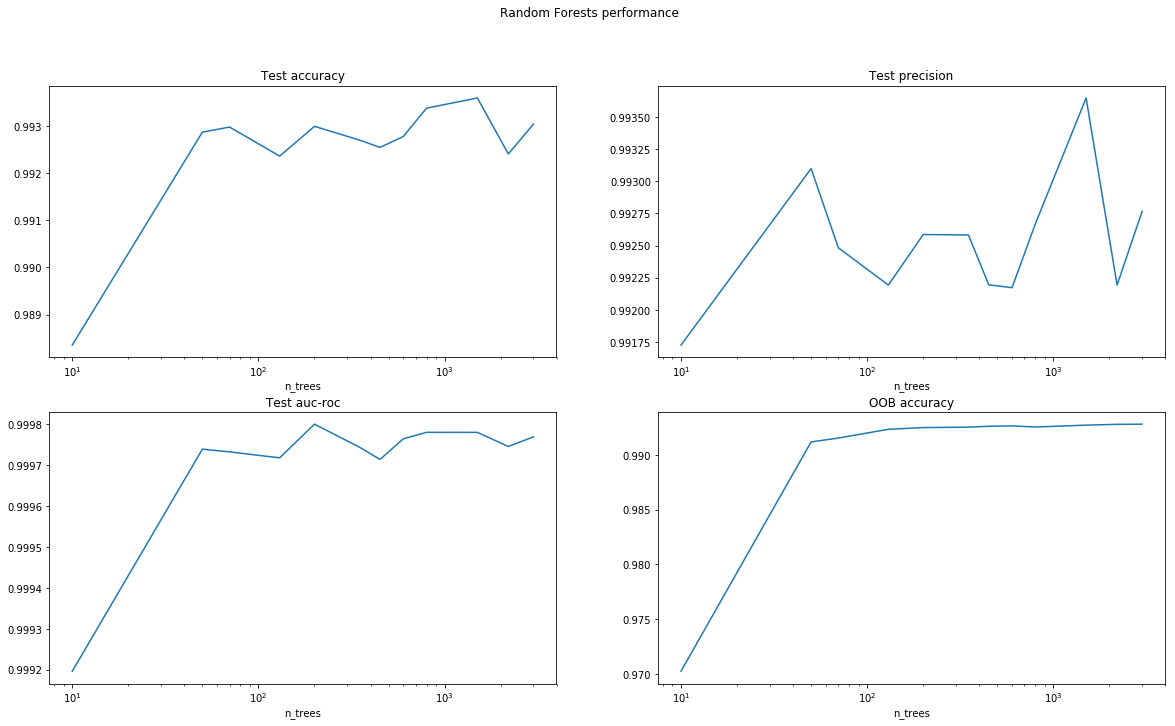

In [27]:
big_n_est = [50, 70, 130, 200, 350, 450, 600, 800, 1150, 1500, 1850, 2200, 3000, 5000, 10000]
f, axes = plt.subplots(2, 2, figsize=(20, 11))
f.suptitle('Random Forests performance')
axes = axes.ravel()
axes[0].plot(big_n_est, forestzilla_accu)
axes[0].set_title('Test accuracy')
axes[0].set_xlabel('n_trees')
axes[0].set_xscale('log')
#axes[0].legend()

axes[1].plot(big_n_est, forestzilla_prec)
axes[1].set_title('Test precision')
axes[1].set_xlabel('n_trees')
axes[1].set_xscale('log')
#axes[1].legend()

axes[2].plot(big_n_est, forestzilla_aucroc)
axes[2].set_title('Test auc-roc')
axes[2].set_xlabel('n_trees')
axes[2].set_xscale('log')
#axes[2].legend()

axes[3].plot(big_n_est, forestzilla_oob)
axes[3].set_title('OOB accuracy')
axes[3].set_xlabel('n_trees')
axes[3].set_xscale('log')
#axes[3].legend()
f.savefig('RF_forestzilla_20k.pdf')

#### 2.3.2 Checking the most important parameters

In [28]:
input_giant_data.drop('target', axis=1).head(0)

,polar,amplitude,center_x,center_y,sig_xy,area,eps,minor_ax


In [29]:
pd.DataFrame(forestzilla_feat_imp, columns=input_giant_data.drop('target', axis=1).columns, index=big_n_est)

,polar,amplitude,center_x,center_y,sig_xy,area,eps,minor_ax
10,0.047354,0.189921,0.113575,0.118196,0.129101,0.143964,0.124855,0.133033
50,0.047494,0.192622,0.114537,0.119021,0.126161,0.138803,0.123860,0.137502
70,0.048378,0.191588,0.115145,0.119238,0.126914,0.134775,0.124665,0.139298
130,0.048066,0.193549,0.114870,0.119155,0.126490,0.135084,0.124988,0.137798
200,0.048101,0.191622,0.115442,0.119423,0.127204,0.135030,0.124547,0.138631
350,0.047940,0.191480,0.115123,0.119256,0.126511,0.136671,0.124746,0.138273
450,0.047677,0.191662,0.115428,0.119325,0.126706,0.137193,0.124075,0.137934
600,0.047699,0.191130,0.115132,0.119343,0.126701,0.136647,0.124538,0.138808
800,0.048013,0.192159,0.115348,0.119286,0.126613,0.136547,0.124176,0.137858
1500,0.047865,0.191671,0.115123,0.119605,0.126431,0.136804,0.124243,0.138257


### 2.4 Another performance check:
* Training on the merged dataset: (C60+C80+C100)=_signal_, (dust-fog+gamma)=_background_.
* Testing on subsamples of different classes **pair-wise**.

Using 100 trees Forest.

AUC_ROC scores
C60keV__dust_fog   	 0.9997354
C60keV__gamma   	 0.99959485
C80keV__dust_fog   	 0.99978565
C80keV__gamma   	 0.99967375
C100keV__dust_fog   	 0.99988947
C100keV__gamma   	 0.99982796
Total AUC_ROC score:  0.999752366981
Wall time: 34.3 s


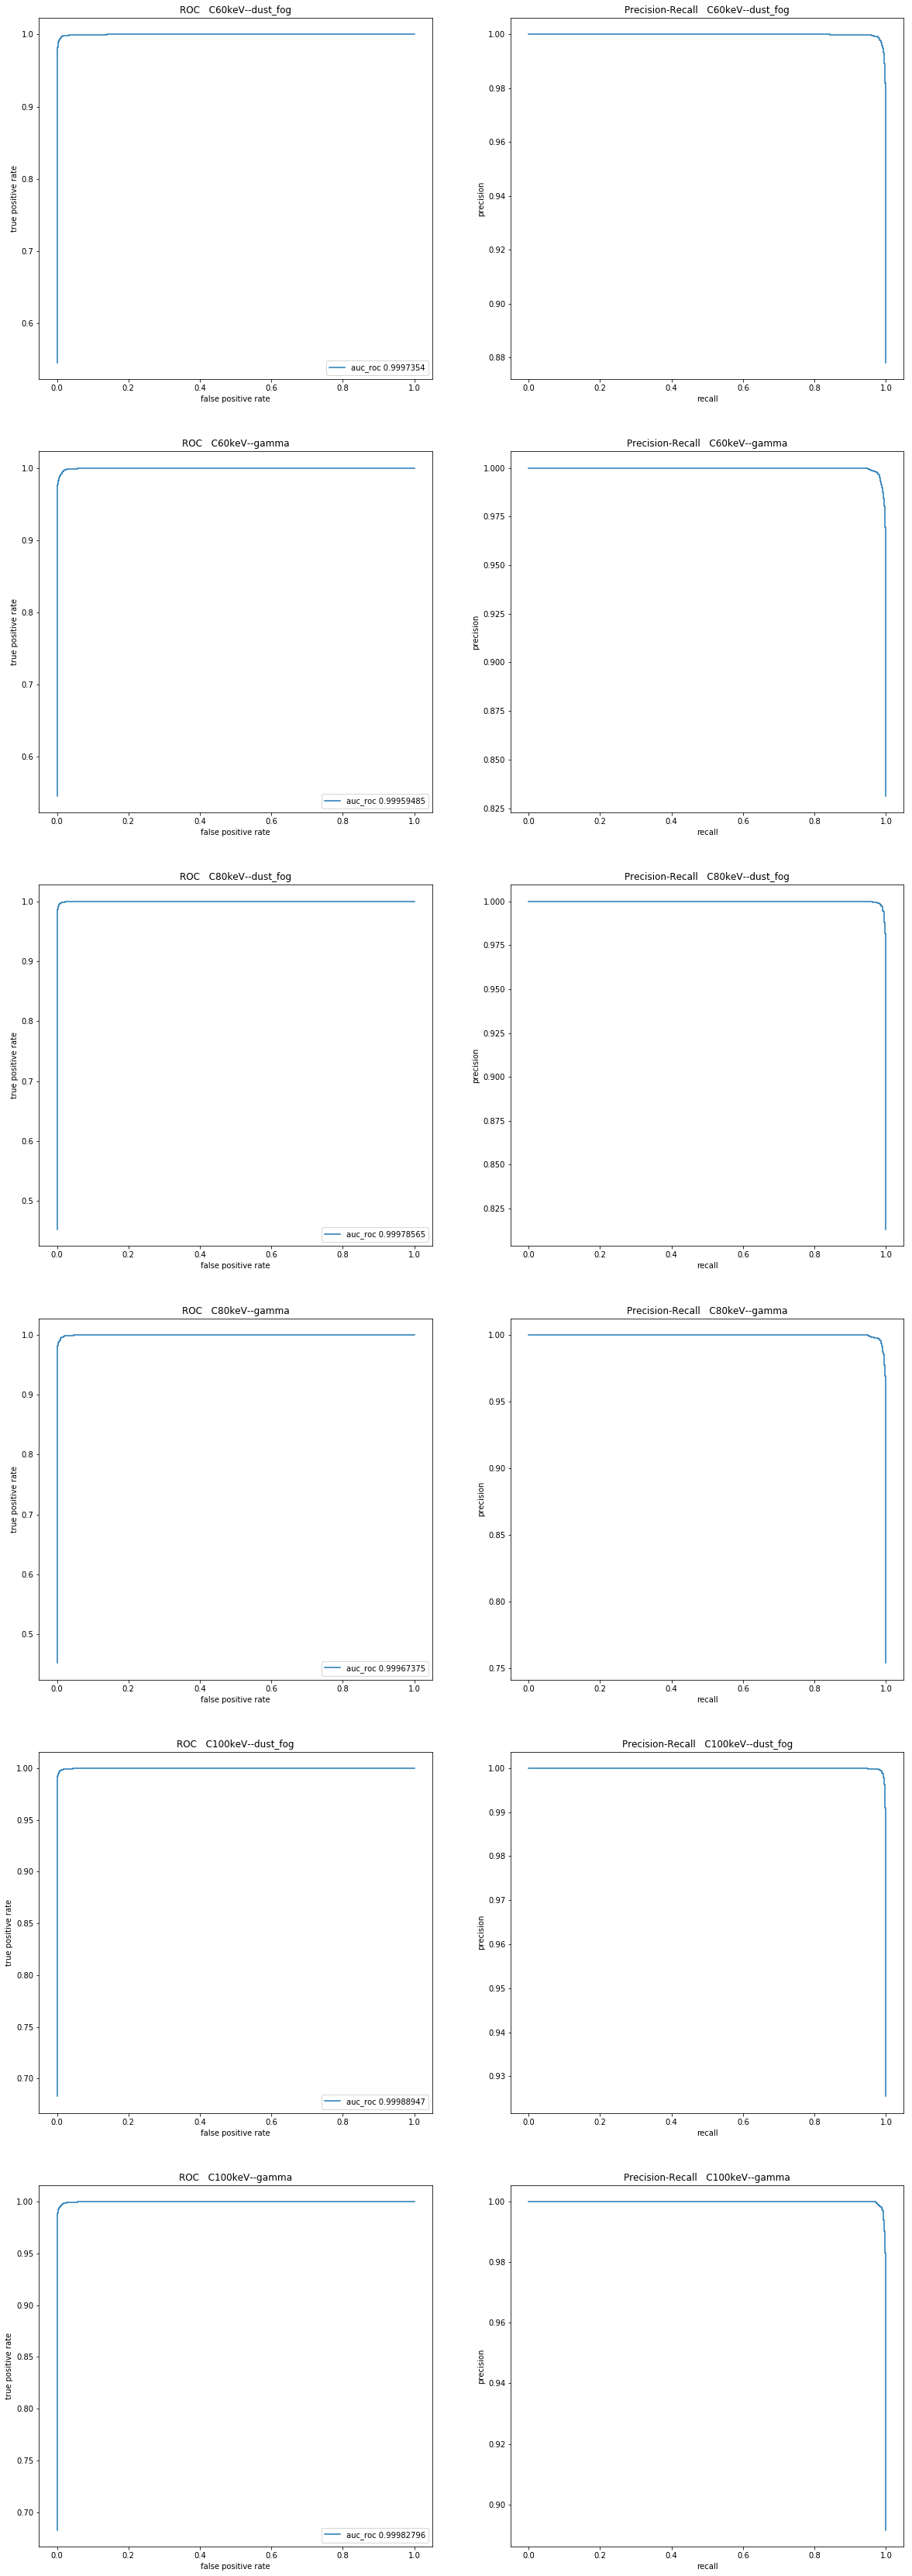

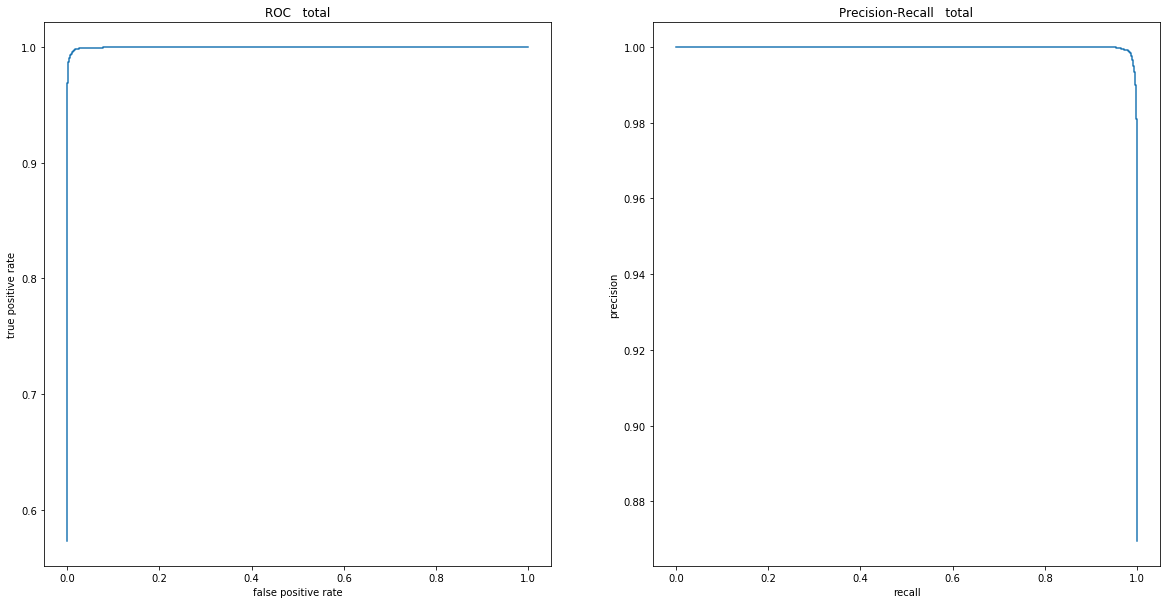

In [30]:
%%time
data_train = {}
data_test = {}
targ_train = {}
targ_test = {}
X_train = pd.DataFrame(columns=feat_giant_data[class_names[0]].columns.values ).values
y_train = []
for name in class_names:
    data_train[name], data_test[name], targ_train[name], targ_test[name] = feat_to_input_split(feat_giant_data, [name], test_size=0.1)
    X_train = np.vstack((X_train, data_train[name]))
    y_train = np.append(y_train, targ_train[name])
    #print ('\n-----------\n',feat_giant_data[name].shape,'\n', data_test[name].shape, '\n', targ_test[name].shape, '\n --------------')

#print ('training shape \n',X_train.shape, y_train.shape,'\n--------')
randcla.set_params(n_estimators=100)
randcla.fit(X_train, y_train)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Testing pair-wise
#print ('testing shapes')
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            X_test = np.vstack((data_test[name1], data_test[name2]))
            y_test = np.append(targ_test[name1], targ_test[name2])
            #print ('==========\n',X_test.shape, y_test.shape,'\n==========')
            
            rand_pred = (randcla.predict_proba(X_test))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=8)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print ('AUC_ROC scores')
for (key,value) in auc_rocs.items():
    print (key,'  \t', np.around(value, decimals=8))
    
X_test = pd.DataFrame(columns=feat_giant_data[class_names[0]].columns.values ).values
y_test = []
for name in class_names:
    X_test = np.vstack((X_test, data_test[name]))
    y_test = np.append(y_test, targ_test[name])
rand_pred = (randcla.predict_proba(X_test))[:,1]
print ('Total AUC_ROC score: ', roc_auc_score(y_test, rand_pred))
fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
f, axes = plt.subplots(1,2, figsize=(20,10))
axes = axes.ravel()
axes[0].step(fpr, tpr)
axes[0].set_title('ROC   total')
axes[0].set_xlabel('false positive rate')
axes[0].set_ylabel('true positive rate')
#axes[0].legend()

prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
axes[1].step(rec, prec)
axes[1].set_title('Precision-Recall   total')
axes[1].set_xlabel('recall')
axes[1].set_ylabel('precision')

###### 2.4.1 Resulting feature importances

In [31]:
pd.DataFrame((randcla.feature_importances_).reshape((1,8)), columns=input_giant_data.drop('target', axis=1).columns, index=[100])

,polar,amplitude,center_x,center_y,sig_xy,area,eps,minor_ax
100,0.047509,0.191621,0.114989,0.119698,0.126555,0.136944,0.124381,0.138303


## 3. Stacking all polarisations together

In [37]:
%%time
giant_stacked_params = {}
for name in class_names:
    giant_stacked_params[name] = params_to_stacked_polar(giant_data_params[name], n_pol=8)

Wall time: 15min 20s


In [38]:
for name in class_names:
    print (giant_stacked_params[name].shape)

(20000, 56)
(20000, 56)
(20000, 56)
(20000, 56)
(20000, 56)


In [130]:
%%time
cleaned_giant_stacked = {}
for name in class_names:
    cleaned_giant_stacked[name] = clean_stacked_params(giant_stacked_params[name], 500)

(15459, 56)
(8191, 56)
(17701, 56)
(14111, 56)
(16366, 56)
Wall time: 2.26 s


* Too many discarded on C80keV. Probably should loosen the constraint?

In [131]:
%%time
feat_giant_stacked = {}
for name in class_names:
    feat_giant_stacked[name] = params_to_feat_stacked(cleaned_giant_stacked[name])

Wall time: 15.5 s


In [132]:
for name in class_names:
    print (feat_giant_stacked[name].shape)
feat_giant_stacked['C100keV'].columns

(15459, 64)
(8191, 64)
(17701, 64)
(14111, 64)
(16366, 64)


Index(['amplitude1', 'center_x1', 'center_y1', 'sig_xy1', 'area1', 'eps1',
       'maj_ax1', 'min_ax1', 'amplitude2', 'center_x2', 'center_y2', 'sig_xy2',
       'area2', 'eps2', 'maj_ax2', 'min_ax2', 'amplitude3', 'center_x3',
       'center_y3', 'sig_xy3', 'area3', 'eps3', 'maj_ax3', 'min_ax3',
       'amplitude4', 'center_x4', 'center_y4', 'sig_xy4', 'area4', 'eps4',
       'maj_ax4', 'min_ax4', 'amplitude5', 'center_x5', 'center_y5', 'sig_xy5',
       'area5', 'eps5', 'maj_ax5', 'min_ax5', 'amplitude6', 'center_x6',
       'center_y6', 'sig_xy6', 'area6', 'eps6', 'maj_ax6', 'min_ax6',
       'amplitude7', 'center_x7', 'center_y7', 'sig_xy7', 'area7', 'eps7',
       'maj_ax7', 'min_ax7', 'amplitude8', 'center_x8', 'center_y8', 'sig_xy8',
       'area8', 'eps8', 'maj_ax8', 'min_ax8'],
      dtype='object')

## 3.1 Training with shuffle in train-test-split

### 3.1.1 Training whole signal vs whole background

In [149]:
%%time
input_giant_stacked = feat_to_input(feat_giant_stacked, class_names)
print (input_giant_stacked.shape)
X_stacked = input_giant_stacked.drop(['target'], axis=1).values
y_stacked = input_giant_stacked.get('target').values
X_stacked_train, X_stacked_test, y_stacked_train, y_stacked_test = train_test_split(X_stacked, y_stacked, test_size=0.1, stratify=y_stacked)

(71828, 65)
Wall time: 305 ms


In [150]:
%%time
randcla.set_params(n_estimators=100, n_jobs=-1)
randcla.fit(X_stacked_train, y_stacked_train)
print ('precision ', precision_score(y_stacked_test, randcla.predict(X_stacked_test)))

precision  0.996373307544
Wall time: 4.1 s


In [151]:
imp_feat_st_sh = randcla.feature_importances_
imp_feat_st_sh

array([ 0.02251985,  0.00841626,  0.01383107,  0.02039099,  0.0166919 ,
        0.01860389,  0.01656861,  0.01718137,  0.02299191,  0.00786477,
        0.00977181,  0.01747854,  0.01655611,  0.01460741,  0.01617594,
        0.01738883,  0.02398338,  0.00839498,  0.0090577 ,  0.01548312,
        0.01692671,  0.01391724,  0.01463453,  0.01460761,  0.0299258 ,
        0.00786568,  0.01006951,  0.01415974,  0.01846688,  0.01555424,
        0.02053078,  0.01565554,  0.02763005,  0.00753871,  0.00947763,
        0.0165182 ,  0.0180556 ,  0.01521472,  0.01711712,  0.01687713,
        0.02505992,  0.00756942,  0.00864413,  0.01740363,  0.01636956,
        0.0155823 ,  0.01464356,  0.01766831,  0.02343571,  0.00834398,
        0.00901093,  0.01740507,  0.01665971,  0.01486556,  0.01363231,
        0.01801501,  0.02242565,  0.0079374 ,  0.00933493,  0.01581756,
        0.01609409,  0.01743132,  0.015701  ,  0.01624709])

### 3.1.2 Comparing signal-background pair-wise

AUC_ROC scores
C60keV__dust_fog   	 0.9998689
C60keV__gamma   	 0.9999905
C80keV__dust_fog   	 0.9998383
C80keV__gamma   	 0.9999385
C100keV__dust_fog   	 0.9999284
C100keV__gamma   	 0.9999598
Wall time: 11.3 s


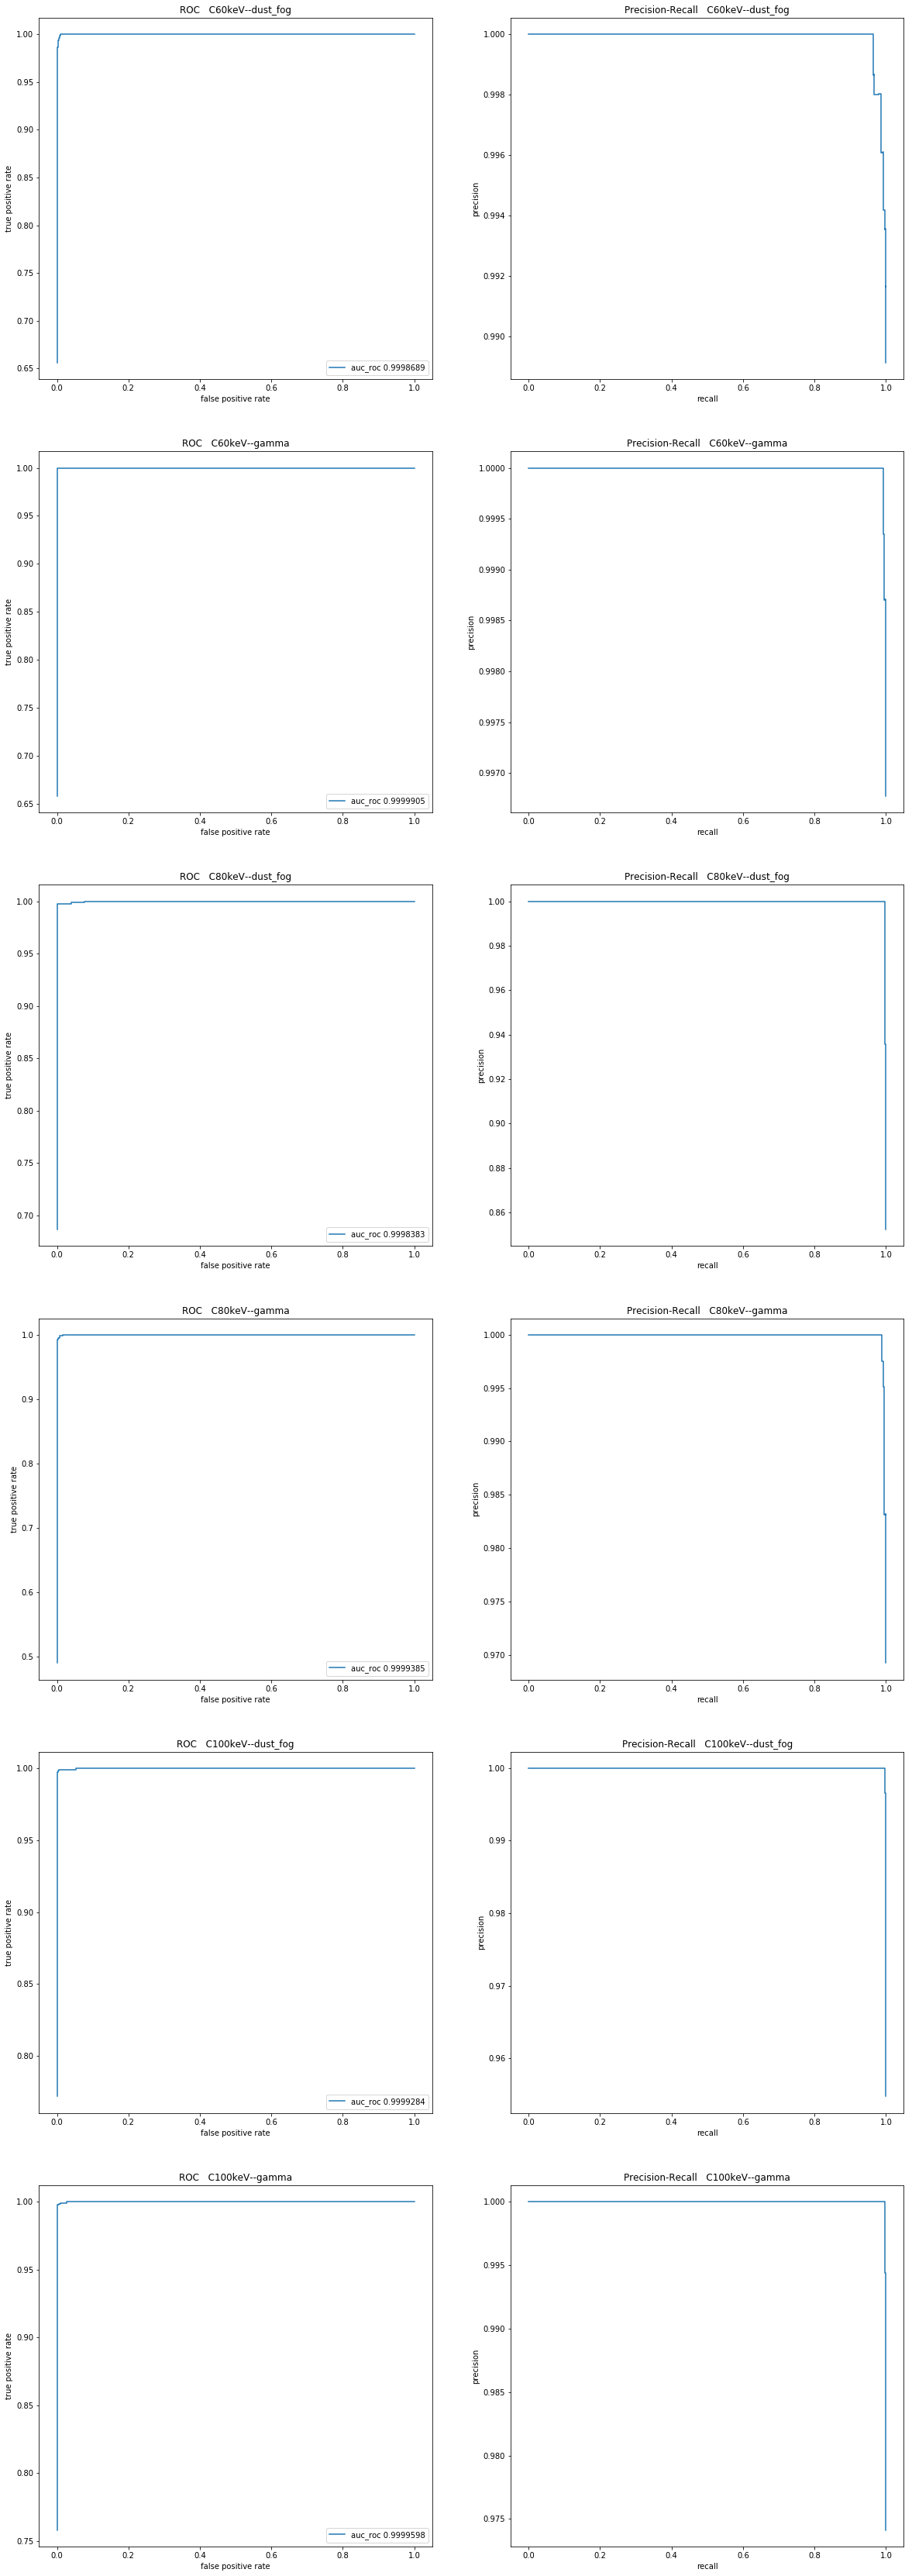

In [136]:
%%time
# Taking the best number of estimators from CV
#randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
randcla.set_params(n_estimators=100, n_jobs=-1)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            input_data = feat_to_input(feat_giant_stacked, [name1, name2])
            X = input_data.drop(['target'], axis=1).values
            y = input_data.get('target').values
            X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_raw, y_train)
            rand_pred = (randcla.predict_proba(X_test_raw))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print ('AUC_ROC scores')
for (key,value) in auc_rocs.items():
    print (key,'  \t', np.around(value, decimals=7))

## 3.2 Training without shuffle in train-test-split

### 3.2.1 Training whole signal vs whole background

In [137]:
%%time
X_stacked_unsh_train, X_stacked_unsh_test, y_stacked_unsh_train, y_stacked_unsh_test = feat_to_input_split(feat_giant_stacked, class_names, test_size=0.1, shuffle=False)

Wall time: 301 ms


In [138]:
%%time
randcla.set_params(n_estimators=100, n_jobs=-1)
randcla.fit(X_stacked_unsh_train, y_stacked_unsh_train)
print ('precision ', precision_score(y_stacked_unsh_test, randcla.predict(X_stacked_unsh_test)))

precision  1.0
Wall time: 4.12 s


In [139]:
imp_feat_st_unsh = randcla.feature_importances_
imp_feat_st_unsh

array([ 0.02399416,  0.00844184,  0.01403468,  0.02010972,  0.01561647,
        0.01877924,  0.01556033,  0.0173697 ,  0.02091807,  0.00855361,
        0.00920347,  0.01767469,  0.01578855,  0.01408834,  0.01557442,
        0.01879986,  0.02480024,  0.00836695,  0.009139  ,  0.01556467,
        0.01611665,  0.01370499,  0.0145152 ,  0.01432415,  0.02543489,
        0.00772077,  0.00966073,  0.01509239,  0.01764646,  0.01619595,
        0.01856294,  0.01538845,  0.0300327 ,  0.00767132,  0.00969897,
        0.01679847,  0.01906338,  0.01467034,  0.01780353,  0.01551575,
        0.02506507,  0.00805715,  0.00900855,  0.01634738,  0.0153403 ,
        0.01522089,  0.01485446,  0.01852355,  0.02432875,  0.00889565,
        0.0083225 ,  0.01762869,  0.01665834,  0.01516122,  0.01471978,
        0.01879931,  0.02512222,  0.00838477,  0.00876285,  0.01655697,
        0.0161282 ,  0.01735141,  0.01504903,  0.01771693])

### 3.2.2 Comparing signal-background pair-wise

AUC_ROC scores
C60keV__dust_fog   	 1.0
C60keV__gamma   	 1.0
C80keV__dust_fog   	 1.0
C80keV__gamma   	 1.0
C100keV__dust_fog   	 1.0
C100keV__gamma   	 1.0
Wall time: 11.9 s


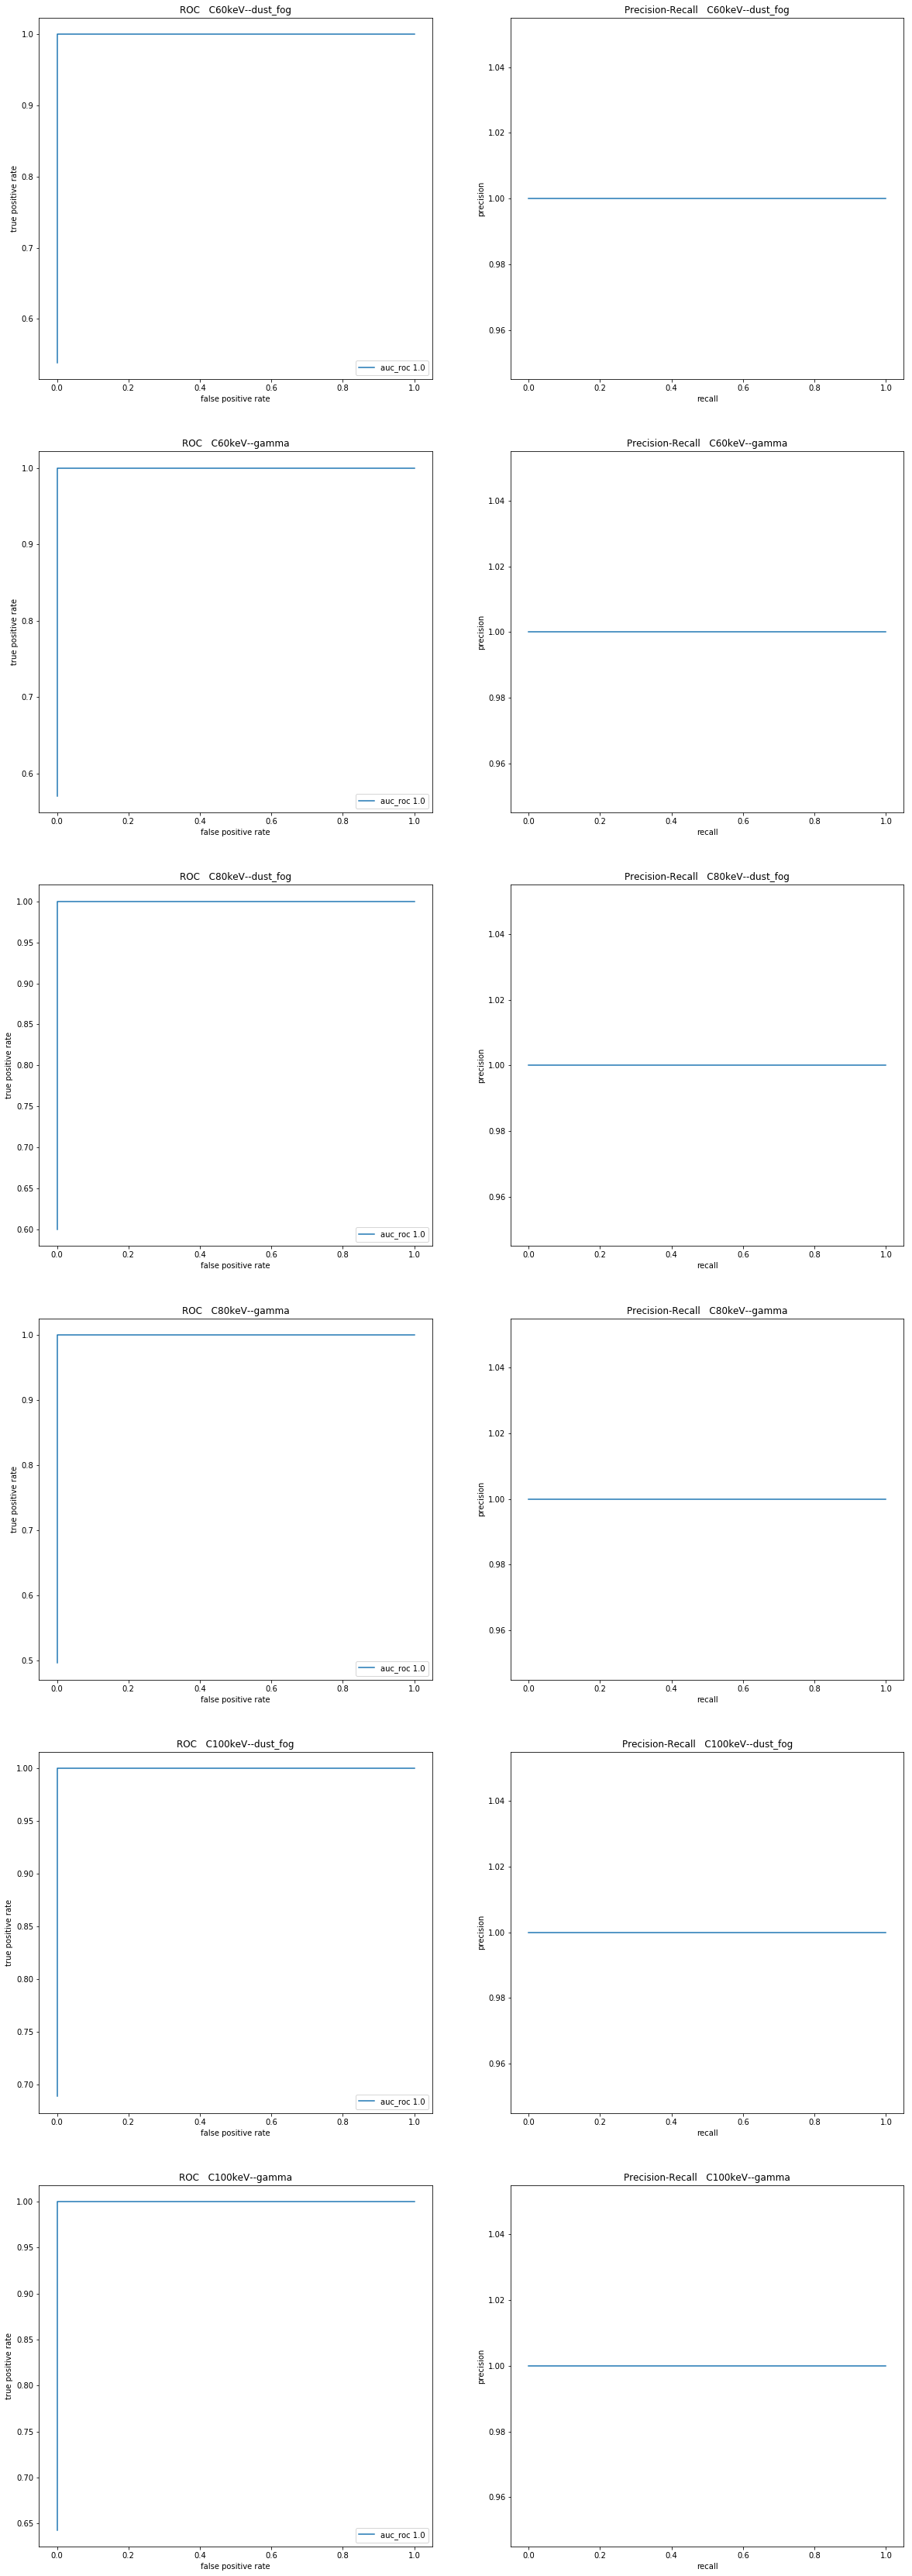

In [140]:
%%time
# Taking the best number of estimators from CV
#randcla.set_params(n_estimators = n_est[np.argmax(giant_rand_scores)])
randcla.set_params(n_estimators=100, n_jobs=-1)

f, axes = plt.subplots(6, 2, figsize=(20, 60))
axes = axes.ravel()
i=0
auc_rocs = {}
##### Creating the pairs of signal-noise for comparison
for name1 in class_names:
    for name2 in class_names:
        if (name1[0] == 'C') and (name2[0] != 'C'):
            X_train_raw, X_test_raw, y_train, y_test = feat_to_input_split(feat_giant_stacked, [name1, name2], test_size=0.1, shuffle=False)
            ##### Scoring the RF and building curves
            randcla.fit(X_train_raw, y_train)
            rand_pred = (randcla.predict_proba(X_test_raw))[:,1]
            auc_rocs[name1+'__'+name2] = roc_auc_score(y_test, rand_pred)
            fpr, tpr, thrsh = roc_curve(y_test, rand_pred)
            axes[i].step(fpr, tpr, label='auc_roc '+str(np.around(auc_rocs[name1+'__'+name2], decimals=7)))
            axes[i].set_title('ROC   '+name1+'--'+name2)
            axes[i].set_xlabel('false positive rate')
            axes[i].set_ylabel('true positive rate')
            axes[i].legend()
            i += 1
            prec, rec, thrsh = precision_recall_curve(y_test, rand_pred)
            axes[i].step(rec, prec)
            axes[i].set_title('Precision-Recall   '+name1+'--'+name2)
            axes[i].set_xlabel('recall')
            axes[i].set_ylabel('precision')
            i += 1
            
            
print ('AUC_ROC scores')
for (key,value) in auc_rocs.items():
    print (key,'  \t', np.around(value, decimals=7))

## 4. Dropping most important features and checking the performance.

### 4.1 Stacked polarizations with no shuffle.

In [141]:
(feat_giant_stacked['C100keV'].columns)[np.argsort(imp_feat_st_unsh)]

Index(['center_x5', 'center_x4', 'center_x6', 'center_y7', 'center_x3',
       'center_x8', 'center_x1', 'center_x2', 'center_y8', 'center_x7',
       'center_y6', 'center_y3', 'center_y2', 'center_y4', 'center_y5', 'eps3',
       'center_y1', 'eps2', 'min_ax3', 'maj_ax3', 'eps5', 'maj_ax7', 'maj_ax6',
       'maj_ax8', 'sig_xy4', 'eps7', 'eps6', 'area6', 'min_ax4', 'min_ax5',
       'maj_ax1', 'sig_xy3', 'maj_ax2', 'area1', 'area2', 'area3', 'area8',
       'eps4', 'sig_xy6', 'sig_xy8', 'area7', 'sig_xy5', 'eps8', 'min_ax1',
       'sig_xy7', 'area4', 'sig_xy2', 'min_ax8', 'maj_ax5', 'min_ax6',
       'maj_ax4', 'eps1', 'min_ax7', 'min_ax2', 'area5', 'sig_xy1',
       'amplitude2', 'amplitude1', 'amplitude7', 'amplitude3', 'amplitude6',
       'amplitude8', 'amplitude4', 'amplitude5'],
      dtype='object')

train_shape  (37219, 62)  auc-roc:  1.0
train_shape  (37219, 60)  auc-roc:  1.0
train_shape  (37219, 58)  auc-roc:  1.0
train_shape  (37219, 55)  auc-roc:  1.0
train_shape  (37219, 52)  auc-roc:  1.0
train_shape  (37219, 49)  auc-roc:  1.0
train_shape  (37219, 44)  auc-roc:  1.0
train_shape  (37219, 39)  auc-roc:  1.0
train_shape  (37219, 32)  auc-roc:  1.0
train_shape  (37219, 24)  auc-roc:  1.0
train_shape  (37219, 4)  auc-roc:  1.0
train_shape  (37219, 2)  auc-roc:  1.0
train_shape  (37219, 1)  auc-roc:  0.999963480753
Wall time: 2min 27s


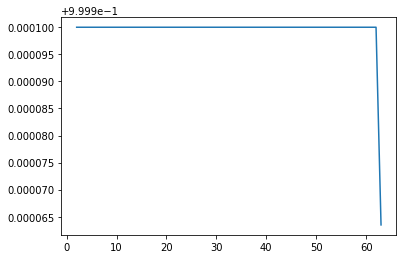

In [184]:
%%time
randcla.set_params(n_estimators = 1000, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    for name in class_names:
        feat_giant_st_dropped[name] = drop_import_feat(clean_quantile_feat(feat_giant_stacked[name], 0.996), imp_feat_st_unsh, n_drop=n)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=False)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('train_shape ',X_train.shape,' auc-roc: ',auc_rocs[-1])
plt.plot(n_drops, auc_rocs)

*  after adding cleaning with quantiles auc-roc = 1.0 even for 1 feature.

### 4.2 Stacked polarizations with shuffle.

In [144]:
(feat_giant_stacked['C100keV'].columns)[np.argsort(imp_feat_st_sh)]

Index(['center_x5', 'center_x1', 'center_x8', 'center_x2', 'center_x3',
       'center_x6', 'center_x4', 'center_x7', 'center_y7', 'center_y8',
       'center_y6', 'center_y2', 'center_y3', 'center_y4', 'center_y5',
       'maj_ax6', 'eps3', 'center_y1', 'maj_ax7', 'eps2', 'min_ax4', 'sig_xy4',
       'sig_xy8', 'eps7', 'maj_ax3', 'area3', 'eps4', 'maj_ax8', 'eps5',
       'min_ax5', 'area8', 'eps6', 'min_ax8', 'min_ax3', 'maj_ax1', 'area7',
       'sig_xy3', 'area2', 'sig_xy6', 'sig_xy5', 'area6', 'sig_xy7', 'maj_ax2',
       'min_ax1', 'min_ax7', 'sig_xy2', 'eps1', 'eps8', 'area1', 'maj_ax5',
       'maj_ax4', 'min_ax2', 'min_ax6', 'area5', 'sig_xy1', 'amplitude2',
       'amplitude3', 'amplitude7', 'area4', 'amplitude8', 'amplitude6',
       'amplitude1', 'amplitude5', 'amplitude4'],
      dtype='object')

train_shape  (33985, 62)  auc-roc:  0.999947067882
train_shape  (33985, 60)  auc-roc:  0.99996015607
train_shape  (33985, 58)  auc-roc:  0.999975242882
train_shape  (33985, 55)  auc-roc:  0.999943900549
train_shape  (33985, 52)  auc-roc:  0.999894539832
train_shape  (33985, 49)  auc-roc:  0.999867981758
train_shape  (33985, 44)  auc-roc:  0.999900010285
train_shape  (33985, 39)  auc-roc:  0.999862541348
train_shape  (33985, 32)  auc-roc:  0.999781020418
train_shape  (33985, 24)  auc-roc:  0.999622369226
train_shape  (33985, 4)  auc-roc:  0.999572551849
train_shape  (33985, 2)  auc-roc:  0.998197075998
train_shape  (33985, 1)  auc-roc:  0.98407598836
Wall time: 46.3 s


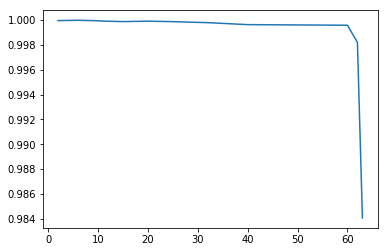

In [176]:
%%time
randcla.set_params(n_estimators = 100, n_jobs = -1)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_sh_dropped = {}
auc_rocs = []
for n in n_drops:
    for name in class_names:
        feat_giant_st_sh_dropped[name] = drop_import_feat(clean_quantile_feat(feat_giant_stacked[name], 0.995), imp_feat_st_sh, n_drop=n)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_sh_dropped, class_names, test_size=0.25, shuffle=True)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('train_shape ',X_train.shape,' auc-roc: ',auc_rocs[-1])
plt.plot(n_drops, auc_rocs)

## 5. Shifting the polarizations in stacked signal data

auc-roc:  1.0
auc-roc:  1.0
auc-roc:  1.0
auc-roc:  1.0
auc-roc:  1.0
auc-roc:  1.0
auc-roc:  1.0
auc-roc:  1.0
Wall time: 35.3 s


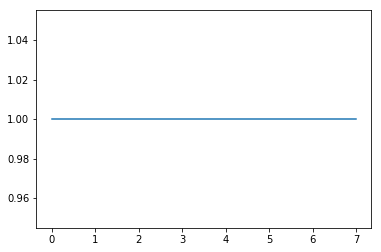

In [159]:
%%time
### NO SHUFFLE
randcla.set_params(n_estimators = 100, n_jobs = -1)
n_pol = 8
auc_rocs = []
feat_giant_stacked_shifted = {}
for n in np.arange(1, n_pol+1):
    for name in class_names:
        if name[0]=='C':
            feat_giant_stacked_shifted[name] = shift_polar_feats(feat_giant_stacked[name], n)
        else: feat_giant_stacked_shifted[name] = feat_giant_stacked[name]
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_stacked_shifted, class_names, test_size=0.1, shuffle=False)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('auc-roc: ',auc_rocs[-1])
plt.plot(auc_rocs)

auc-roc:  0.999935738165
auc-roc:  0.999941255948
auc-roc:  0.999942563066
auc-roc:  0.999951692477
auc-roc:  0.999919623222
auc-roc:  0.999935315153
auc-roc:  0.999937832249
auc-roc:  0.999956323684
Wall time: 39 s


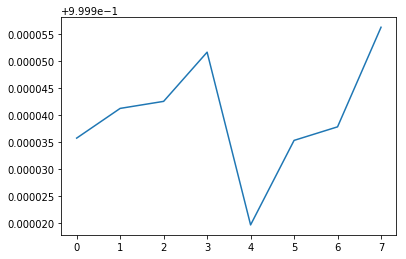

In [160]:
%%time
### WITH SHUFFLE
randcla.set_params(n_estimators = 100, n_jobs = -1)
n_pol = 8
auc_rocs = []
feat_giant_stacked_shifted = {}
for n in np.arange(1, n_pol+1):
    for name in class_names:
        if name[0]=='C':
            feat_giant_stacked_shifted[name] = shift_polar_feats(feat_giant_stacked[name], n)
        else: feat_giant_stacked_shifted[name] = feat_giant_stacked[name]
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_stacked_shifted, class_names, test_size=0.1, shuffle=True)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('auc-roc: ',auc_rocs[-1])
plt.plot(auc_rocs)

## 6. Dropping random features.

### 6.1 Without shuffling the data

train_shape  (53869, 62)  auc-roc:  1.0 

train_shape  (53869, 60)  auc-roc:  1.0 

train_shape  (53869, 58)  auc-roc:  1.0 

train_shape  (53869, 55)  auc-roc:  1.0 

train_shape  (53869, 52)  auc-roc:  1.0 

train_shape  (53869, 49)  auc-roc:  1.0 

train_shape  (53869, 44)  auc-roc:  1.0 

train_shape  (53869, 39)  auc-roc:  1.0 

train_shape  (53869, 32)  auc-roc:  1.0 

train_shape  (53869, 24)  auc-roc:  1.0 

Index(['min_ax2', 'maj_ax4', 'min_ax7', 'center_y8'], dtype='object')
Index(['min_ax2', 'maj_ax4', 'min_ax7', 'center_y8'], dtype='object')
Index(['min_ax2', 'maj_ax4', 'min_ax7', 'center_y8'], dtype='object')
Index(['min_ax2', 'maj_ax4', 'min_ax7', 'center_y8'], dtype='object')
Index(['min_ax2', 'maj_ax4', 'min_ax7', 'center_y8'], dtype='object')
train_shape  (53869, 4)  auc-roc:  1.0 

Index(['amplitude7', 'area7'], dtype='object')
Index(['amplitude7', 'area7'], dtype='object')
Index(['amplitude7', 'area7'], dtype='object')
Index(['amplitude7', 'area7'], dtype='object')
I

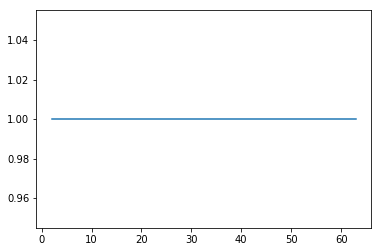

In [204]:
%%time
### NOT SHUFFLE DATA
randcla.set_params(n_estimators = 1000, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_giant_stacked['C100keV'].columns)[np.argsort(imp_feat_st_unsh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_giant_stacked[name].drop(shuffle_cols[-n:], axis=1)
        if feat_giant_st_dropped[name].shape[1]<10: print(feat_giant_st_dropped[name].columns)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=False)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1],'\n')
plt.plot(n_drops, auc_rocs)

train_shape  (53869, 62)  auc-roc:  1.0 

train_shape  (53869, 60)  auc-roc:  1.0 

train_shape  (53869, 58)  auc-roc:  1.0 

train_shape  (53869, 55)  auc-roc:  1.0 

train_shape  (53869, 52)  auc-roc:  1.0 

train_shape  (53869, 49)  auc-roc:  1.0 

train_shape  (53869, 44)  auc-roc:  1.0 

train_shape  (53869, 39)  auc-roc:  1.0 

train_shape  (53869, 32)  auc-roc:  1.0 

train_shape  (53869, 24)  auc-roc:  1.0 

Index(['center_x3', 'maj_ax3', 'min_ax6', 'sig_xy7'], dtype='object')
Index(['center_x3', 'maj_ax3', 'min_ax6', 'sig_xy7'], dtype='object')
Index(['center_x3', 'maj_ax3', 'min_ax6', 'sig_xy7'], dtype='object')
Index(['center_x3', 'maj_ax3', 'min_ax6', 'sig_xy7'], dtype='object')
Index(['center_x3', 'maj_ax3', 'min_ax6', 'sig_xy7'], dtype='object')
train_shape  (53869, 4)  auc-roc:  1.0 

Index(['min_ax3', 'eps8'], dtype='object')
Index(['min_ax3', 'eps8'], dtype='object')
Index(['min_ax3', 'eps8'], dtype='object')
Index(['min_ax3', 'eps8'], dtype='object')
Index(['min_ax3',

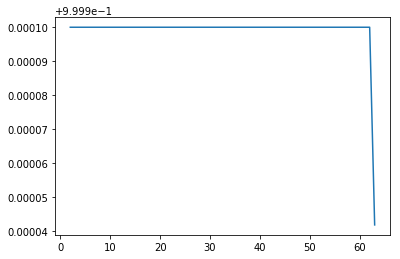

In [205]:
%%time
### NOT SHUFFLE DATA
randcla.set_params(n_estimators = 1000, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_giant_stacked['C100keV'].columns)[np.argsort(imp_feat_st_unsh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_giant_stacked[name].drop(shuffle_cols[-n:], axis=1)
        if feat_giant_st_dropped[name].shape[1]<10: print(feat_giant_st_dropped[name].columns)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=False)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1],'\n')
plt.plot(n_drops, auc_rocs)

train_shape  (53869, 62)  auc-roc:  1.0 

train_shape  (53869, 60)  auc-roc:  1.0 

train_shape  (53869, 58)  auc-roc:  1.0 

train_shape  (53869, 55)  auc-roc:  1.0 

train_shape  (53869, 52)  auc-roc:  1.0 

train_shape  (53869, 49)  auc-roc:  1.0 

train_shape  (53869, 44)  auc-roc:  1.0 

train_shape  (53869, 39)  auc-roc:  1.0 

train_shape  (53869, 32)  auc-roc:  1.0 

train_shape  (53869, 24)  auc-roc:  1.0 

Index(['center_x3', 'eps5', 'area7', 'amplitude8'], dtype='object')
Index(['center_x3', 'eps5', 'area7', 'amplitude8'], dtype='object')
Index(['center_x3', 'eps5', 'area7', 'amplitude8'], dtype='object')
Index(['center_x3', 'eps5', 'area7', 'amplitude8'], dtype='object')
Index(['center_x3', 'eps5', 'area7', 'amplitude8'], dtype='object')
train_shape  (53869, 4)  auc-roc:  1.0 

Index(['amplitude4', 'area8'], dtype='object')
Index(['amplitude4', 'area8'], dtype='object')
Index(['amplitude4', 'area8'], dtype='object')
Index(['amplitude4', 'area8'], dtype='object')
Index(['amp

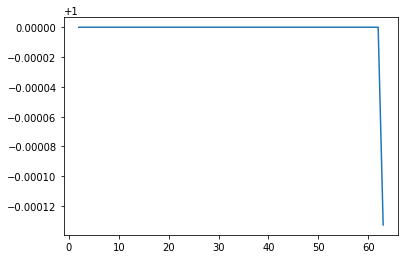

In [206]:
%%time
### NOT SHUFFLE DATA
randcla.set_params(n_estimators = 1000, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_giant_stacked['C100keV'].columns)[np.argsort(imp_feat_st_unsh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_giant_stacked[name].drop(shuffle_cols[-n:], axis=1)
        if feat_giant_st_dropped[name].shape[1]<10: print(feat_giant_st_dropped[name].columns)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=False)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1],'\n')
plt.plot(n_drops, auc_rocs)

### 6.2 With shuflling the data

train_shape  (53871, 62)  auc-roc:  0.99986841796 

train_shape  (53871, 60)  auc-roc:  0.999888112566 

train_shape  (53871, 58)  auc-roc:  0.999842956034 

train_shape  (53871, 55)  auc-roc:  0.999769861398 

train_shape  (53871, 52)  auc-roc:  0.999790390656 

train_shape  (53871, 49)  auc-roc:  0.999746203977 

train_shape  (53871, 44)  auc-roc:  0.999779932092 

train_shape  (53871, 39)  auc-roc:  0.999720336169 

train_shape  (53871, 32)  auc-roc:  0.999751182645 

train_shape  (53871, 24)  auc-roc:  0.999728272982 

Index(['center_y2', 'eps2', 'amplitude3', 'maj_ax3'], dtype='object')
Index(['center_y2', 'eps2', 'amplitude3', 'maj_ax3'], dtype='object')
Index(['center_y2', 'eps2', 'amplitude3', 'maj_ax3'], dtype='object')
Index(['center_y2', 'eps2', 'amplitude3', 'maj_ax3'], dtype='object')
Index(['center_y2', 'eps2', 'amplitude3', 'maj_ax3'], dtype='object')
train_shape  (53871, 4)  auc-roc:  0.998973493548 

Index(['min_ax1', 'amplitude7'], dtype='object')
Index(['min_ax1', 'a

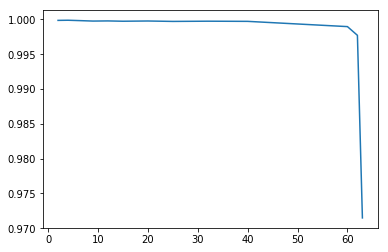

In [207]:
%%time
### SHUFFLE DATA
randcla.set_params(n_estimators = 1000, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_giant_stacked['C100keV'].columns)[np.argsort(imp_feat_st_sh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_giant_stacked[name].drop(shuffle_cols[-n:], axis=1)
        if feat_giant_st_dropped[name].shape[1]<10: print(feat_giant_st_dropped[name].columns)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=True)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1],'\n')
plt.plot(n_drops, auc_rocs)

train_shape  (53871, 62)  auc-roc:  0.99976007563 

train_shape  (53871, 60)  auc-roc:  0.999786480247 

train_shape  (53871, 58)  auc-roc:  0.999871475619 

train_shape  (53871, 55)  auc-roc:  0.999778671052 

train_shape  (53871, 52)  auc-roc:  0.99985426263 

train_shape  (53871, 49)  auc-roc:  0.999845680787 

train_shape  (53871, 44)  auc-roc:  0.99980487172 

train_shape  (53871, 39)  auc-roc:  0.999805225554 

train_shape  (53871, 32)  auc-roc:  0.999835968451 

train_shape  (53871, 24)  auc-roc:  0.999853047282 

Index(['eps1', 'min_ax1', 'area7', 'min_ax7'], dtype='object')
Index(['eps1', 'min_ax1', 'area7', 'min_ax7'], dtype='object')
Index(['eps1', 'min_ax1', 'area7', 'min_ax7'], dtype='object')
Index(['eps1', 'min_ax1', 'area7', 'min_ax7'], dtype='object')
Index(['eps1', 'min_ax1', 'area7', 'min_ax7'], dtype='object')
train_shape  (53871, 4)  auc-roc:  0.99900401477 

Index(['amplitude1', 'maj_ax2'], dtype='object')
Index(['amplitude1', 'maj_ax2'], dtype='object')
Index(['a

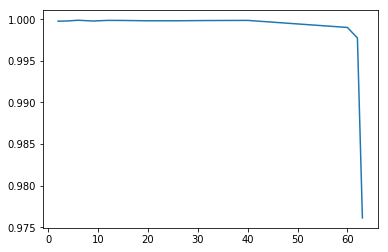

In [208]:
%%time
### NOT SHUFFLE DATA
randcla.set_params(n_estimators = 1000, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_giant_stacked['C100keV'].columns)[np.argsort(imp_feat_st_sh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_giant_stacked[name].drop(shuffle_cols[-n:], axis=1)
        if feat_giant_st_dropped[name].shape[1]<10: print(feat_giant_st_dropped[name].columns)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=True)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1],'\n')
plt.plot(n_drops, auc_rocs)

train_shape  (53871, 62)  auc-roc:  0.999830069912 

train_shape  (53871, 60)  auc-roc:  0.999882478251 

train_shape  (53871, 58)  auc-roc:  0.999844821614 

train_shape  (53871, 55)  auc-roc:  0.999808632464 

train_shape  (53871, 52)  auc-roc:  0.999824316534 

train_shape  (53871, 49)  auc-roc:  0.999850863701 

train_shape  (53871, 44)  auc-roc:  0.999775269499 

train_shape  (53871, 39)  auc-roc:  0.99984908923 

train_shape  (53871, 32)  auc-roc:  0.99984335287 

train_shape  (53871, 24)  auc-roc:  0.999807356828 

Index(['center_x1', 'center_y2', 'area2', 'center_x8'], dtype='object')
Index(['center_x1', 'center_y2', 'area2', 'center_x8'], dtype='object')
Index(['center_x1', 'center_y2', 'area2', 'center_x8'], dtype='object')
Index(['center_x1', 'center_y2', 'area2', 'center_x8'], dtype='object')
Index(['center_x1', 'center_y2', 'area2', 'center_x8'], dtype='object')
train_shape  (53871, 4)  auc-roc:  0.99692097704 

Index(['amplitude1', 'eps1'], dtype='object')
Index(['amplitu

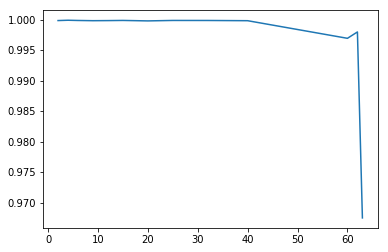

In [209]:
%%time
### NOT SHUFFLE DATA
randcla.set_params(n_estimators = 1000, n_jobs = -1, oob_score=False)
n_drops = [2, 4, 6, 9, 12, 15, 20, 25, 32, 40, 60, 62, 63]
feat_giant_st_dropped = {}
auc_rocs = []
for n in n_drops:
    shuffle_cols = np.copy((feat_giant_stacked['C100keV'].columns)[np.argsort(imp_feat_st_sh)].values)
    np.random.shuffle(shuffle_cols)
    #print(shuffle_cols,'\n')
    for name in class_names:
        feat_giant_st_dropped[name] = feat_giant_stacked[name].drop(shuffle_cols[-n:], axis=1)
        if feat_giant_st_dropped[name].shape[1]<10: print(feat_giant_st_dropped[name].columns)
    X_train, X_test, y_train, y_test = feat_to_input_split(feat_giant_st_dropped, class_names, test_size=0.25, shuffle=True)
    randcla.fit(X_train, y_train)
    auc_rocs.append(roc_auc_score(y_test, (randcla.predict_proba(X_test))[:,1]))
    print('train_shape ', X_train.shape, ' auc-roc: ', auc_rocs[-1],'\n')
plt.plot(n_drops, auc_rocs)

# 51. TESTING AREA

##### <font color='red'> RANDOM CODE HAPPENS </font>

In [111]:
copa = giant_stacked_params['C100keV']
copa.get(['height1','sig_xy2']).head(1)

,height1,sig_xy2
0,27.763805,42.027276


In [55]:
feat_giant_data[class_names[0]].columns

Index([u'polar', u'amplitude', u'center_x', u'center_y', u'sig_xy', u'area',
       u'eps', u'minor_ax'],
      dtype='object')

In [57]:
copa = pd.DataFrame(giant_data_params['C100keV'][8:16].drop(['img_num','polar'],axis=1).values, index=giant_data_params['C100keV'][0:8].get('polar'), columns=giant_data_params['C100keV'].drop(['img_num','polar'],axis=1).columns)
popa = giant_data_params['C100keV'][8:16].get('img_num').values[0]
print (popa)
copa

2.0


,height,amplitude,center_x,center_y,sig_x,sig_y,sig_xy
polar,,,,,,,
1.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731
2.0,24.334133,59.645606,14.329225,14.533185,5.816713,7.875631,0.212840
3.0,23.411457,43.812067,14.374567,14.622436,6.872459,7.786300,0.029967
4.0,22.962829,40.218924,14.459931,14.381284,7.435987,7.190080,0.771465
5.0,23.170918,51.184038,14.415665,14.109579,6.711545,6.680334,1.437820
6.0,23.867563,69.552265,14.395915,14.036434,5.886534,6.656973,1.605094
7.0,24.712152,87.158119,14.413304,14.024474,5.364566,6.851709,1.447891
8.0,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264


In [84]:
jopa = pd.DataFrame(index=[popa])
for i in copa.index:
    nonopa = [iopa+str(int(i)) for iopa in copa.loc[i].index.values]
    print (nonopa)
    nopa = np.append(jopa.columns.values, [iopa+str(int(i)) for iopa in copa.loc[i].index.values])
    jopa = pd.DataFrame(np.append(jopa.values, copa.loc[i].values).reshape((1,-1)), columns=nopa, index=[popa])
jopa

['height1', 'amplitude1', 'center_x1', 'center_y1', 'sig_x1', 'sig_y1', 'sig_xy1']
['height2', 'amplitude2', 'center_x2', 'center_y2', 'sig_x2', 'sig_y2', 'sig_xy2']
['height3', 'amplitude3', 'center_x3', 'center_y3', 'sig_x3', 'sig_y3', 'sig_xy3']
['height4', 'amplitude4', 'center_x4', 'center_y4', 'sig_x4', 'sig_y4', 'sig_xy4']
['height5', 'amplitude5', 'center_x5', 'center_y5', 'sig_x5', 'sig_y5', 'sig_xy5']
['height6', 'amplitude6', 'center_x6', 'center_y6', 'sig_x6', 'sig_y6', 'sig_xy6']
['height7', 'amplitude7', 'center_x7', 'center_y7', 'sig_x7', 'sig_y7', 'sig_xy7']
['height8', 'amplitude8', 'center_x8', 'center_y8', 'sig_x8', 'sig_y8', 'sig_xy8']


,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.40959,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264


In [85]:
copa2 = pd.DataFrame(giant_data_params['C100keV'][16:24].drop(['img_num','polar'],axis=1).values, index=giant_data_params['C100keV'][0:8].get('polar'), columns=giant_data_params['C100keV'].drop(['img_num','polar'],axis=1).columns)
popa2 = giant_data_params['C100keV'][16:24].get('img_num').values[0]
print (popa2)
copa2

3.0


,height,amplitude,center_x,center_y,sig_x,sig_y,sig_xy
polar,,,,,,,
1.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935
2.0,28.150002,193.093463,15.341466,29.623590,179.288465,70.205519,69.682300
3.0,26.575359,173.597672,16.182299,31.565013,186.966754,87.170490,78.841862
4.0,25.343270,165.480687,18.744609,35.355382,230.600249,127.183139,113.694306
5.0,24.531754,160.666713,19.298515,36.990574,275.335511,153.809152,136.748951
6.0,25.261131,147.165516,16.298500,33.159565,268.532100,118.681782,110.958290
7.0,26.574131,159.993785,14.602538,30.339340,237.000104,88.380695,84.656662
8.0,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624


In [86]:
jopa2 = pd.DataFrame(index=[popa2])
for i in copa2.index:
    nonopa = [iopa+str(int(i)) for iopa in copa2.loc[i].index.values]
    print (nonopa)
    nopa = np.append(jopa2.columns.values, [iopa+str(int(i)) for iopa in copa2.loc[i].index.values])
    jopa2 = pd.DataFrame(np.append(jopa2.values, copa2.loc[i].values).reshape((1,-1)), columns=nopa, index=[popa2])
jopa2

['height1', 'amplitude1', 'center_x1', 'center_y1', 'sig_x1', 'sig_y1', 'sig_xy1']
['height2', 'amplitude2', 'center_x2', 'center_y2', 'sig_x2', 'sig_y2', 'sig_xy2']
['height3', 'amplitude3', 'center_x3', 'center_y3', 'sig_x3', 'sig_y3', 'sig_xy3']
['height4', 'amplitude4', 'center_x4', 'center_y4', 'sig_x4', 'sig_y4', 'sig_xy4']
['height5', 'amplitude5', 'center_x5', 'center_y5', 'sig_x5', 'sig_y5', 'sig_xy5']
['height6', 'amplitude6', 'center_x6', 'center_y6', 'sig_x6', 'sig_y6', 'sig_xy6']
['height7', 'amplitude7', 'center_x7', 'center_y7', 'sig_x7', 'sig_y7', 'sig_xy7']
['height8', 'amplitude8', 'center_x8', 'center_y8', 'sig_x8', 'sig_y8', 'sig_xy8']


,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
3.0,29.01699,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.24594,14.161763,29.1112,206.849392,72.375468,69.179624


In [87]:
pd.concat([jopa, jopa2])

,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264
3.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624


In [91]:
range(1,9)

[1, 2, 3, 4, 5, 6, 7, 8]

In [92]:
cocopa = pd.DataFrame()
pd.concat([cocopa, jopa, jopa2])

,height1,amplitude1,center_x1,center_y1,sig_x1,sig_y1,sig_xy1,height2,amplitude2,center_x2,...,sig_x7,sig_y7,sig_xy7,height8,amplitude8,center_x8,center_y8,sig_x8,sig_y8,sig_xy8
2.0,25.391546,74.408202,14.409590,14.512226,5.404071,7.672402,0.463731,24.334133,59.645606,14.329225,...,5.364566,6.851709,1.447891,25.332947,94.885925,14.385614,14.038993,5.075495,7.051571,1.182264
3.0,29.016990,202.473188,14.385854,28.860082,181.625226,64.368335,63.250935,28.150002,193.093463,15.341466,...,237.000104,88.380695,84.656662,28.079039,182.245940,14.161763,29.111200,206.849392,72.375468,69.179624
